# Parsing Build Request from Google Sheet

**Inputs**

* spreadsheetId
* sheetname
* token path
* credentials.json (required from Google)

**Outputs**



In [1]:
# inputs
spreadsheet_id = '1aDZv-A8JRGZbtVFugOsB6w-001pni8DDIoj1IXdRcMQ'
sheetname = 'Design'

token_path = 'token.pickle'
creds_path = 'credentials.json'

## Get build request data from GoogleSheets

In [2]:
from __future__ import print_function
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request


SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']


def get_creds():
    creds = None

    if os.path.exists(token_path):
        with open(token_path, 'rb') as token:
            creds = pickle.load(token)

    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                creds_path, SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open(token_path, 'wb') as token:
            pickle.dump(creds, token)
    return creds

creds = get_creds()
service = build('sheets', 'v4', credentials=creds)

In [3]:
# execute the request
request = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=sheetname)
data = request.execute()

In [4]:
# parse the values
from aqbt.build_request import parse_parts, CellValue

values = CellValue.to_cell_values(data['values'])

parts = parse_parts(values)

In [ ]:
name_to_part_dict = {p['name'].lower(): p for p in parts}
assert len(name_to_part_dict) == len(parts)

composite_parts = [p for p in parts if p['partType'] == 'composite part']

strains = [s for s in composite_parts if 'strain' in s['name'].lower()]

for s in strains:
    for p in s['parts']:
        part = name_to_part_dict[p.lower()]
        if part['partType'] == 'basic part':
            raise Exception("{} is not a composite part".format(p))

In [8]:
strains

[{'name': 'SM_doxy_ataf1_2bs_stable_gfp_strain',
  'collection': 'doxy_ataf1_strains',
  'partType': 'composite part',
  'description': 'Doxy-inducible ATAF1 TF that activates GFP expression. 2 ATAF1 binding sites infront of promoter that drives expression of stable GFP. Tet protein driven by strong promoter and tagged with medium strength activation domain',
  'parts': ['strong_exp_med_ad_tet',
   'Input_node_doxy_ataf1',
   'output_node_2b2_ataf1_stable_gfp']},
 {'name': 'MM_doxy_ataf1_2bs_stable_gfp_strain',
  'collection': 'doxy_ataf1_strains',
  'partType': 'composite part',
  'description': 'Doxy-inducible ATAF1 TF that activates GFP expression. 2 ATAF1 binding sites infront of promoter that drives expression of stable GFP. Tet protein driven by medium strength promoter and tagged with medium strength activation domain',
  'parts': ['medium_exp_med_ad_tet',
   'Input_node_doxy_ataf1',
   'output_node_2b2_ataf1_stable_gfp']},
 {'name': 'WM_doxy_ataf1_2bs_stable_gfp_strain',
  'col

## Build dependency graph

In [5]:
import networkx as nx
from typing import *

name_to_part_dict = {p['name']: p for p in parts}
assert len(name_to_part_dict) == len(parts)

def get_dependency_graph(parts: List[dict]) -> nx.DiGraph:

    # create dependency graph
    g = nx.DiGraph()

    for p in parts:
        g.add_node(p['name'], part=p)

    for p in parts:
        if p['partType'] == 'composite part':
            for p2 in p['parts']:
                g.add_edge(p2, p['name'])
    g.name = 'Dependency Graph'
    return g

def is_a_leaf(g, n):
    return len(list(g.successors(n))) == 0

def leaves(g):
    """Returns the leaves of this graph."""
    leaves = []
    for n in g.nodes:
        if is_a_leaf(g, n):
            leaves.append(n)
    return leaves

def is_strain(g, n):
    part = name_to_part_dict[n]
    if part['partType'] == 'composite part':
        if is_a_leave(n):
            return True
    return False

g = get_dependency_graph(parts)

print(nx.info(g))
print()

strains = []
for l in leaves(g):
    part = name_to_part_dict[l]
    if part['partType'] == 'composite part':
        strains.append(part['name'])
        
    
print("Number of strains: {}".format(len(strains)))

IndentationError: expected an indented block (<ipython-input-5-595d5d4ba6bf>, line 43)

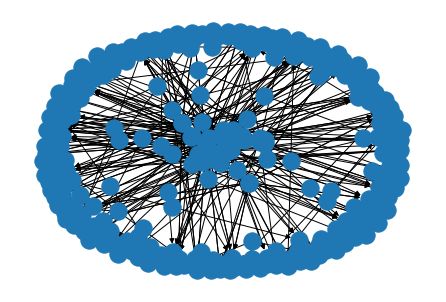

In [17]:
from networkx.drawing.nx_agraph import graphviz_layout


# pos=nx.spectral_layout(g)
nx.draw(g)
